# News Summarization Using Fine-tuned LLMs -- T5, PEGASUS and BART

There are 2 summarization types:
- Extractive Summarization: 
Extractive summarization involves identifying and extracting key phrases, sentences, or segments directly from the original text to form a condensed version. It's akin to highlighting parts of the text that are deemed most informative or relevant.

- Abtractive Summarization:
Abstractive summarization goes beyond mere extraction; it involves understanding the main ideas and then expressing them in new words. It's akin to reading a text and then explaining it in one's own words.

What we gonna do is Abtractive Summarization.

Env: Google Cloud Vertex AI 
- Zone: us-east4-c
- GPUs/CPUs: Graphics Optimized: 1 * NVIDIA L4 GPU 24GB Memory, 4 vCPUs, 16GB RAM
- Pytorch

## Part1: Data Preprocessing and EDA

In [1]:
!nvidia-smi

Mon Nov 20 01:35:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA L4           On   | 00000000:00:03.0 Off |                    0 |
| N/A   74C    P8    20W /  72W |      0MiB / 23034MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings("ignore") 

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

In [4]:
import transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer, AutoModel
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, BartForConditionalGeneration
from transformers import DataCollatorForSeq2Seq, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import create_optimizer, AdamWeightDecay
from transformers import pipeline
import datasets
from datasets import Dataset, DatasetDict
#from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from rouge import Rouge

In [5]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
df = pd.read_csv("news_summary.csv", encoding="latin-1")
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [7]:
df.describe()

,author,date,headlines,read_more,text,ctext
count,4514,4514,4514,4514,4514,4396
unique,45,240,4514,4461,4514,4341
top,Chhavi Tyagi,"19 Jul 2017,Wednesday",More than half of India's languages may die in...,http://indiatoday.intoday.in/story/assembly-el...,At least 400 languages or more than half langu...,AAJ TAK LIVE TV WITH LIVE ELECTION RESULTS I c...
freq,559,76,1,13,1,13


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     4514 non-null   object
 1   date       4514 non-null   object
 2   headlines  4514 non-null   object
 3   read_more  4514 non-null   object
 4   text       4514 non-null   object
 5   ctext      4396 non-null   object
dtypes: object(6)
memory usage: 211.7+ KB


In [9]:
df = df[['headlines', 'text', 'ctext']]
df.head()

,headlines,text,ctext
0,Daman & Diu revokes mandatory Rakshabandhan in...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika slams user who trolled her for 'divorc...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Aaj aapne pakad liya: LeT man Dujana before be...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotel staff to get training to spot signs of s...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [10]:
# drop na
df = df.dropna()
df.describe()

,headlines,text,ctext
count,4396,4396,4396
unique,4396,4396,4341
top,More than half of India's languages may die in...,At least 400 languages or more than half langu...,AAJ TAK LIVE TV WITH LIVE ELECTION RESULTS I c...
freq,1,1,13


In [11]:
# Converting to lowercase
df['ctext'] = df['ctext'].apply(str.lower)
df['text'] = df['text'].apply(str.lower)
df['headlines'] = df['headlines'].apply(str.lower)
df.head()

,headlines,text,ctext
0,daman & diu revokes mandatory rakshabandhan in...,the administration of union territory daman an...,the daman and diu administration on wednesday ...
1,malaika slams user who trolled her for 'divorc...,malaika arora slammed an instagram user who tr...,"from her special numbers to tv?appearances, bo..."
2,'virgin' now corrected to 'unmarried' in igims...,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...
3,aaj aapne pakad liya: let man dujana before be...,lashkar-e-taiba's kashmir commander abu dujana...,lashkar-e-taiba's kashmir commander abu dujana...
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...,hotels in mumbai and other indian cities are t...


In [12]:
df['headlines_length'] = [len(x.split()) for x in df.headlines]
df['text_length'] = [len(x.split()) for x in df.text]
df['ctext_length'] = [len(x.split()) for x in df.ctext]
df.head()

,headlines,text,ctext,headlines_length,text_length,ctext_length
0,daman & diu revokes mandatory rakshabandhan in...,the administration of union territory daman an...,the daman and diu administration on wednesday ...,9,60,364
1,malaika slams user who trolled her for 'divorc...,malaika arora slammed an instagram user who tr...,"from her special numbers to tv?appearances, bo...",10,60,396
2,'virgin' now corrected to 'unmarried' in igims...,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...,8,60,335
3,aaj aapne pakad liya: let man dujana before be...,lashkar-e-taiba's kashmir commander abu dujana...,lashkar-e-taiba's kashmir commander abu dujana...,10,60,404
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...,hotels in mumbai and other indian cities are t...,11,60,526


In [13]:
df = df[df['ctext_length'] >= df['text_length']]
df.describe()

,headlines_length,text_length,ctext_length
count,4274.000000,4274.000000,4274.000000
mean,9.300889,58.299719,351.740056
std,1.407168,2.314246,358.884472
min,4.000000,44.000000,50.000000
25%,8.000000,57.000000,193.000000
50%,9.000000,59.000000,288.000000
75%,10.000000,60.000000,416.000000
max,14.000000,62.000000,12202.000000


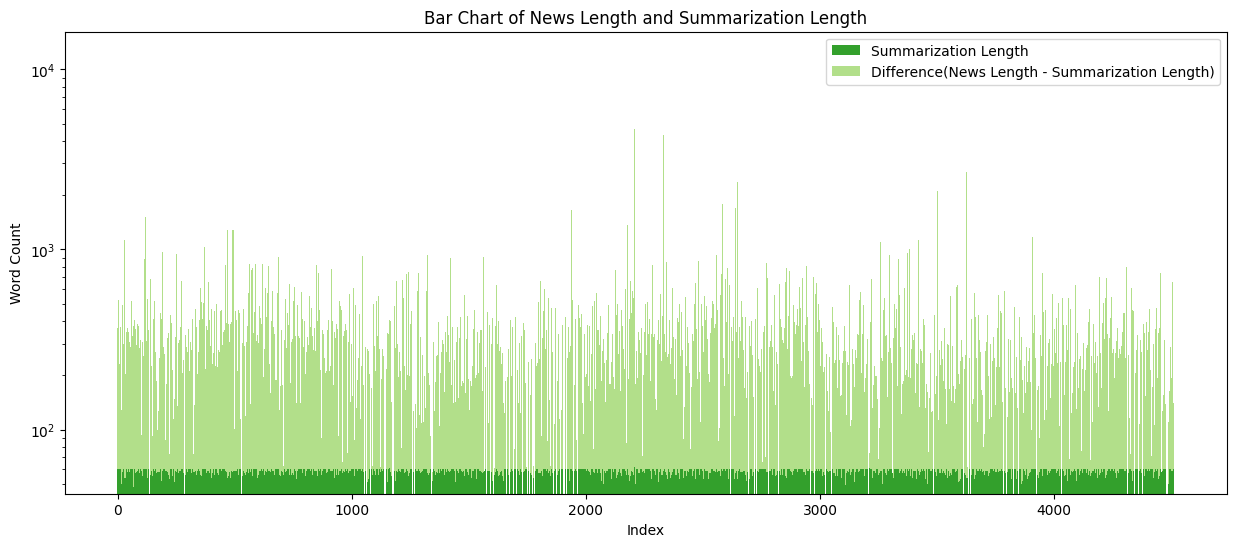

In [14]:
df['diff'] = df['ctext_length'] - df['text_length']
#sns.set(style="whitegrid")
color1 = sns.color_palette("Paired")[3] 
color2 = sns.color_palette("Paired")[2]  

plt.figure(figsize=(15, 6))
bar1 = plt.bar(df.index, df['text_length'], color=color1, label='Summarization Length', width=1.0)
bar2 = plt.bar(df.index, df['diff'], bottom=df['text_length'], color=color2, label='Difference(News Length - Summarization Length)', width=1.0)

plt.xlabel('Index')
plt.ylabel('Word Count')
plt.title('Bar Chart of News Length and Summarization Length')
plt.legend()
plt.yscale('log')
plt.show()

In [15]:
df = df.drop(columns=['headlines_length', 'text_length', 'ctext_length', 'diff'])
df.head()

,headlines,text,ctext
0,daman & diu revokes mandatory rakshabandhan in...,the administration of union territory daman an...,the daman and diu administration on wednesday ...
1,malaika slams user who trolled her for 'divorc...,malaika arora slammed an instagram user who tr...,"from her special numbers to tv?appearances, bo..."
2,'virgin' now corrected to 'unmarried' in igims...,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...
3,aaj aapne pakad liya: let man dujana before be...,lashkar-e-taiba's kashmir commander abu dujana...,lashkar-e-taiba's kashmir commander abu dujana...
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...,hotels in mumbai and other indian cities are t...


In [16]:
df['news'] = df['headlines'] + '. ' + df['ctext']
df.rename(columns={"text": "summary"}, inplace = True)
df = df.drop(columns=['headlines', 'ctext'])
df.head()

,summary,news
0,the administration of union territory daman an...,daman & diu revokes mandatory rakshabandhan in...
1,malaika arora slammed an instagram user who tr...,malaika slams user who trolled her for 'divorc...
2,the indira gandhi institute of medical science...,'virgin' now corrected to 'unmarried' in igims...
3,lashkar-e-taiba's kashmir commander abu dujana...,aaj aapne pakad liya: let man dujana before be...
4,hotels in maharashtra will train their staff t...,hotel staff to get training to spot signs of s...


In [17]:
# Making the dataset
prefix = 'summarize: '
df['news'] = prefix + df['news']
df.head()

,summary,news
0,the administration of union territory daman an...,summarize: daman & diu revokes mandatory raksh...
1,malaika arora slammed an instagram user who tr...,summarize: malaika slams user who trolled her ...
2,the indira gandhi institute of medical science...,summarize: 'virgin' now corrected to 'unmarrie...
3,lashkar-e-taiba's kashmir commander abu dujana...,summarize: aaj aapne pakad liya: let man dujan...
4,hotels in maharashtra will train their staff t...,summarize: hotel staff to get training to spot...


In [18]:
# Converting the pandas dataset to huggingface dataset
# first split the train and test set
train_df, test_df = train_test_split(df, test_size=0.01, shuffle=True)
print("train and val shape:", train_df.shape, "test shape:",test_df.shape)
# save for every model inference
global_train_df = train_df
global_test_df = test_df
train_df = datasets.Dataset.from_pandas(train_df)
train_df = train_df.remove_columns(["__index_level_0__"])
# split train into train and val
train_df = train_df.train_test_split(test_size=0.2, shuffle=True) # split train and test
train_df["train"][0]

train and val shape: (4231, 2) test shape: (43, 2)


{'summary': 'the bengaluru police on tuesday arrested seven people, including a hawala operator, for converting demonetised notes into new currency. the police have also recovered ?93 lakh in new currency from the middlemen after multiple government agency raids. further, the cbi has also registered cases against the officials of four karnataka banks on charges of converting old notes into new ones.',
 'news': 'summarize: 7 held for converting old notes into new in bengaluru. seven people, including a hawala operator, were arrested in bengaluru today as part of a racket that converted black money in banned rs 500 and rs 1000 notes into the new rs 2000 currency notes.rs 93 lakh in new currency was found with the middlemen after multiple government agencies raided them.\xa0one of the arrested has been identified as kv virendra, who is believed to be running a casino in goa. he was produced before a special court in bengaluru which has sent him to six days of cbi custody for questioning.t

In [19]:
# Fitting into dataset dict
train_val_test_dataset = DatasetDict({
    'train': train_df["train"],
    'val': train_df['test']})

print(type(train_val_test_dataset))
train_val_test_dataset

<class 'datasets.dataset_dict.DatasetDict'>


DatasetDict({
    train: Dataset({
        features: ['summary', 'news'],
        num_rows: 3384
    })
    val: Dataset({
        features: ['summary', 'news'],
        num_rows: 847
    })
})

In [20]:
def prepare_dataset(data):
    inputs = data["news"]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)
    labels = tokenizer(text_target=data["summary"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [21]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = Rouge().get_scores(decoded_preds, decoded_labels, avg=True, ignore_empty=True)

    # prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    # result["gen_len"] = np.mean(prediction_lens)

    return result

## [Text-To-Text Transfer Transformer (T5)](https://huggingface.co/docs/transformers/model_doc/t5)

T5 is an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is converted into a text-to-text format. The T5 model was presented in [Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer](https://arxiv.org/pdf/1910.10683.pdf) by Colin Raffel, Noam Shazeer, Adam Roberts, Katherine Lee, Sharan Narang, Michael Matena, Yanqi Zhou, Wei Li, Peter J. Liu.

T5 works well on a variety of tasks out-of-the-box by prepending a different prefix to the input corresponding to each task, e.g., for translation: translate English to German: …, for summarization: summarize: …

![T5](https://camo.githubusercontent.com/623b4dea0b653f2ad3f36c71ebfe749a677ac0a1/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f343030362f312a44304a31674e51663876727255704b657944387750412e706e67)

### T5 Fine-tuning

In [22]:
# tokenize the data
model_name = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [23]:
tokenized_data = train_val_test_dataset.map(prepare_dataset, batched=True)

Map:   0%|          | 0/3384 [00:00<?, ? examples/s]

Map:   0%|          | 0/847 [00:00<?, ? examples/s]

In [24]:
tokenized_data["train"]

Dataset({
    features: ['summary', 'news', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3384
})

Now create a batch of examples using [DataCollatorForSeq2Seq](https://huggingface.co/docs/transformers/v4.35.0/en/main_classes/data_collator#transformers.DataCollatorForSeq2Seq). It’s more efficient to dynamically pad the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [25]:
# Padding
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)

In [26]:
# prepare the model
T5model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [27]:
# set up hyper-parameters
training_args = Seq2SeqTrainingArguments(
    output_dir="t5-news",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    report_to="none"
)

In [28]:
# setup trainer
trainer = Seq2SeqTrainer(
    model = T5model,
    args = training_args,
    train_dataset = tokenized_data["train"],
    eval_dataset = tokenized_data["val"],
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics
)

In [29]:
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge-1,Rouge-2,Rouge-l
1,No log,1.319141,"{'r': 0.15126518671941575, 'p': 0.6610498391307822, 'f': 0.24346445799582436}","{'r': 0.06909807368668162, 'p': 0.38346073648785656, 'f': 0.11572111449931494}","{'r': 0.14099252867181974, 'p': 0.6168981241382111, 'f': 0.22698685488348022}"
2,No log,1.289619,"{'r': 0.1525239134058738, 'p': 0.6656847823604196, 'f': 0.24547257846404047}","{'r': 0.06998339773798573, 'p': 0.3881967168766596, 'f': 0.11721576387595199}","{'r': 0.14200284757697781, 'p': 0.6208435255278791, 'f': 0.2286158963692574}"
3,1.458800,1.279126,"{'r': 0.15420417084086563, 'p': 0.6733302569905806, 'f': 0.2482181306714381}","{'r': 0.07247727268640175, 'p': 0.40203066518175196, 'f': 0.12142154593334124}","{'r': 0.14381709654707744, 'p': 0.6291636333201722, 'f': 0.2315801240010184}"
4,1.458800,1.275695,"{'r': 0.1539475344553024, 'p': 0.6726527729896019, 'f': 0.24782817399843007}","{'r': 0.07249820126718223, 'p': 0.4029008677196051, 'f': 0.12147852983332616}","{'r': 0.14351476598776514, 'p': 0.6281331375139976, 'f': 0.23110779026430733}"


TrainOutput(global_step=848, training_loss=1.4205372648419075, metrics={'train_runtime': 879.4689, 'train_samples_per_second': 15.391, 'train_steps_per_second': 0.964, 'total_flos': 8242854006620160.0, 'train_loss': 1.4205372648419075, 'epoch': 4.0})

In [30]:
# save the model
model_path = "t5-news"
trainer.save_model(model_path)

### T5 Inference
Try the fine-tuned T5 model for our news test set!

In [31]:
# Free up memory
torch.cuda.empty_cache()

In [32]:
# load the model
model = AutoModelForSeq2SeqLM.from_pretrained("t5-news")

In [33]:
#for i in range(len(test_df['news']):
for i in range(5):
    print("original_news: ",test_df['news'].iloc[i])
    summarizer = pipeline("summarization", model = model, tokenizer = tokenizer, max_length = 100)
    summary = summarizer(test_df['news'].iloc[i])
    print(summary[0])
    print()

original_news:  summarize: science express flagged off for climate change awareness. new delhi, feb 17 (pti) a science express train was flagged off today on a seven-month journey that will cover 68 stations across the country, including agartala and lumding in the northeast, to spread awareness about climate change. named science express climate action special, with the collaborative efforts of ministries of railways, environment and science and technology, the 16-coach train will travel to tripura and to the north bank of the brahmaputra for the first time. exhibits of eight coaches of the train are devoted to information, caste studies and materials related to various aspects of climate change. the exhibitions mounted by the environment ministry will also showcase the underlying science, impacts, adaption activities, mitigation solutions and policy approaches in a manner that is easy to understand and interesting for not just school students but also the masses. the focus is on what

Token indices sequence length is longer than the specified maximum sequence length for this model (740 > 512). Running this sequence through the model will result in indexing errors


{'summary_text': 'a science express train was flagged off today on a seven-month journey that will cover 68 stations across the country, including agartala and lumding in the northeast. the train, named science express climate action special, will travel to tripura and to the north bank of the brahmaputra for the first time. exhibits of eight coaches of the train are devoted to information, caste studies and materials related to various aspects of climate'}

original_news:  summarize: leftists celebrate when our jawans die: kiren rijiju. union minister kiren rijiju has accused left parties of misleading people amid the raging controversy over delhi university student gurmehar kaur's social media posts . kaur, daughter of captain mandeep singh who was martyred in a terrorist attack in jammu and kashmir in 1999, is at the centre of a huge row which erupted after her posts on social media against the violence which took place at du's ramjas college last week."she(gurmehar kaur) is a young

## [PEGASUS](https://huggingface.co/docs/transformers/model_doc/pegasus)

The Pegasus model was proposed in [PEGASUS: Pre-training with Extracted Gap-sentences for Abstractive Summarization](https://arxiv.org/pdf/1912.08777.pdf) by Jingqing Zhang, Yao Zhao, Mohammad Saleh and Peter J. Liu on Dec 18, 2019.

According to the abstract,Pegasus’ pretraining task is intentionally similar to summarization: important sentences are removed/masked from an input document and are generated together as one output sequence from the remaining sentences, similar to an extractive summary.
Pegasus achieves SOTA summarization performance on all 12 downstream tasks, as measured by ROUGE and human eval.
![Pegasus](https://production-media.paperswithcode.com/methods/f8b904da-2aaa-4b73-85cd-a8adfacce042.png)

Ref: https://colab.research.google.com/github/abhimishra91/transformers-tutorials/blob/master/transformers_summarization_wandb.ipynb#scrollTo=j9TNdHlQ0CLz

In [34]:
# Free up memory
torch.cuda.empty_cache()

In [35]:
# tokenize the data
model_name = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = False)
tokenized_data = train_val_test_dataset.map(prepare_dataset, batched=True)

Map:   0%|          | 0/3384 [00:00<?, ? examples/s]

Map:   0%|          | 0/847 [00:00<?, ? examples/s]

In [36]:
# Padding
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)

In [37]:
# model
PEGASUSmodel = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
# set up hyper-parameters
training_args = Seq2SeqTrainingArguments(
    output_dir="pegasus-news",
    evaluation_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=False, # FP16 not supported for PEGASUS: https://huggingface.co/docs/transformers/model_doc/pegasus#checkpoints
    report_to="none"
)

In [39]:
# setup trainer
trainer = Seq2SeqTrainer(
    model = PEGASUSmodel,
    args = training_args,
    train_dataset = tokenized_data["train"],
    eval_dataset = tokenized_data["val"],
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics
)

In [40]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge-1,Rouge-2,Rouge-l
1,No log,2.069897,"{'r': 0.3726788874248043, 'p': 0.3995562278312168, 'f': 0.3774477031775325}","{'r': 0.16801465382058134, 'p': 0.18355330883104226, 'f': 0.17076277482918784}","{'r': 0.33789919649146194, 'p': 0.3630648264869712, 'f': 0.3426353352122299}"
2,2.745500,1.977377,"{'r': 0.39196258894703817, 'p': 0.4028061100223781, 'f': 0.38869549773455014}","{'r': 0.18189618469586705, 'p': 0.18994216402253805, 'f': 0.18064299244610635}","{'r': 0.3558599440954195, 'p': 0.3670341581740442, 'f': 0.3535216132968263}"
3,2.509200,1.952163,"{'r': 0.39748068839901274, 'p': 0.403828566060428, 'f': 0.3920508038639299}","{'r': 0.18640759495999973, 'p': 0.1913161682896203, 'f': 0.18373201162604894}","{'r': 0.360871149130211, 'p': 0.3674143351424154, 'f': 0.3563069242865033}"


TrainOutput(global_step=1269, training_loss=2.581139530695922, metrics={'train_runtime': 3945.8447, 'train_samples_per_second': 2.573, 'train_steps_per_second': 0.322, 'total_flos': 1.4607077849628672e+16, 'train_loss': 2.581139530695922, 'epoch': 3.0})

In [41]:
# save the model
model_path = "pegasus-news"
trainer.save_model(model_path)

### PEGASUS Inference
Try the fine-tuned PEGASUS model for our news test set!

In [42]:
model = AutoModelForSeq2SeqLM.from_pretrained("pegasus-news")

In [43]:
#for i in range(len(test_df['news']):
for i in range(5):
    print("original_news: ",test_df['news'].iloc[i])
    summarizer = pipeline("summarization", model = model,tokenizer = tokenizer, max_length = 100)
    summary = summarizer(test_df['news'].iloc[i])
    print(summary[0])
    print()

original_news:  summarize: science express flagged off for climate change awareness. new delhi, feb 17 (pti) a science express train was flagged off today on a seven-month journey that will cover 68 stations across the country, including agartala and lumding in the northeast, to spread awareness about climate change. named science express climate action special, with the collaborative efforts of ministries of railways, environment and science and technology, the 16-coach train will travel to tripura and to the north bank of the brahmaputra for the first time. exhibits of eight coaches of the train are devoted to information, caste studies and materials related to various aspects of climate change. the exhibitions mounted by the environment ministry will also showcase the underlying science, impacts, adaption activities, mitigation solutions and policy approaches in a manner that is easy to understand and interesting for not just school students but also the masses. the focus is on what


## [BART](https://huggingface.co/docs/transformers/model_doc/bart)

The Bart model was proposed in [BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension](https://arxiv.org/abs/1910.13461) by Mike Lewis, Yinhan Liu, Naman Goyal, Marjan Ghazvininejad, Abdelrahman Mohamed, Omer Levy, Ves Stoyanov and Luke Zettlemoyer on 29 Oct, 2019.

BART is a denoising autoencoder for pretraining sequence-to-sequence models. It is trained by (1) corrupting text with an arbitrary noising function, and (2) learning a model to reconstruct the original text. It uses a standard Transformer-based neural machine translation architecture. It uses a standard seq2seq/NMT architecture with a bidirectional encoder (like BERT) and a left-to-right decoder (like GPT). This means the encoder's attention mask is fully visible, like BERT, and the decoder's attention mask is causal, like GPT2.

The pretraining task involves randomly shuffling the order of the original sentences and a novel in-filling scheme, where spans of text are replaced with a single mask token.
BART is particularly effective when fine tuned for text generation but also works well for comprehension tasks. It matches the performance of RoBERTa with comparable training resources on GLUE and SQuAD, achieves new state-of-the-art results on a range of abstractive dialogue, question answering, and summarization tasks, with gains of up to 6 ROUGE.

![BART1](https://blog.paperspace.com/content/images/2022/08/bart.png) 

In [44]:
# Free up memory
torch.cuda.empty_cache()

In [45]:
# tokenize the data
model_name = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_data = train_val_test_dataset.map(prepare_dataset, batched=True)

Map:   0%|          | 0/3384 [00:00<?, ? examples/s]

Map:   0%|          | 0/847 [00:00<?, ? examples/s]

In [46]:
# Padding
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)

In [47]:
# model
BARTmodel = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [48]:
# set up hyper-parameters
training_args = Seq2SeqTrainingArguments(
    output_dir="bart-news",
    evaluation_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True, 
    report_to="none"
)

In [49]:
# setup trainer
trainer = Seq2SeqTrainer(
    model = BARTmodel,
    args = training_args,
    train_dataset = tokenized_data["train"],
    eval_dataset = tokenized_data["val"],
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics
)

In [50]:
trainer.train()

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge-1,Rouge-2,Rouge-l
1,No log,1.372020,"{'r': 0.4925518725107793, 'p': 0.45546155644797204, 'f': 0.4689730647343442}","{'r': 0.26434819795798503, 'p': 0.240554743582075, 'f': 0.2491225017638573}","{'r': 0.4472959132596455, 'p': 0.41448242503813826, 'f': 0.42634987370904165}"
2,1.507800,1.338476,"{'r': 0.5047932996312304, 'p': 0.4600000742568973, 'f': 0.47754145530375325}","{'r': 0.2756573799897272, 'p': 0.24550094313296203, 'f': 0.257360913608345}","{'r': 0.45802994446826895, 'p': 0.41803858542731975, 'f': 0.4336689216292323}"
3,1.371900,1.329648,"{'r': 0.5082278449472777, 'p': 0.46154832486728575, 'f': 0.47997338460063044}","{'r': 0.27815304232741456, 'p': 0.24689479589361238, 'f': 0.2592473339629072}","{'r': 0.46185303361075364, 'p': 0.4201767441262921, 'f': 0.436568611418483}"


TrainOutput(global_step=1269, training_loss=1.4194699791682057, metrics={'train_runtime': 2097.092, 'train_samples_per_second': 4.841, 'train_steps_per_second': 0.605, 'total_flos': 1.0978450331271168e+16, 'train_loss': 1.4194699791682057, 'epoch': 3.0})

In [51]:
# save the model
model_path = "bart-news"
trainer.save_model(model_path)

### BART Inference
Try the fine-tuned PEGASUS model for our news test set!

In [52]:
model = AutoModelForSeq2SeqLM.from_pretrained("bart-news")

In [53]:
#for i in range(len(test_df['news']):
for i in range(5):
    print("original_news: ",test_df['news'].iloc[i])
    summarizer = pipeline("summarization", model = model,tokenizer = tokenizer, max_length = 100)
    summary = summarizer(test_df['news'].iloc[i])
    print(summary[0])
    print()

original_news:  summarize: science express flagged off for climate change awareness. new delhi, feb 17 (pti) a science express train was flagged off today on a seven-month journey that will cover 68 stations across the country, including agartala and lumding in the northeast, to spread awareness about climate change. named science express climate action special, with the collaborative efforts of ministries of railways, environment and science and technology, the 16-coach train will travel to tripura and to the north bank of the brahmaputra for the first time. exhibits of eight coaches of the train are devoted to information, caste studies and materials related to various aspects of climate change. the exhibitions mounted by the environment ministry will also showcase the underlying science, impacts, adaption activities, mitigation solutions and policy approaches in a manner that is easy to understand and interesting for not just school students but also the masses. the focus is on what

### Conclusion

bart-large-cnn = 1.5 * pegasus-large = 2 * t5-base